In [1]:
import pandas as pd
import numpy as np
#import tensorflow as tf
from tqdm import tqdm
import feather

In [54]:
from boto.s3.connection import S3Connection
from boto.s3.key import Key
import sys, os
import re
import json
from urllib.request import FancyURLopener
import cv2
import glob
import zipfile
from multiprocessing import Pool
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from matplotlib import pyplot as plt
from sklearn import linear_model


In [13]:
init_notebook_mode(connected=True)

In [3]:
KEY_FILE = '..//..//..//data//aws_keys//keys.txt'

f = open(KEY_FILE,'rb')
key_data = str(f.read())
keys = re.findall(pattern='\=([a-zA-Z0-9]*)',string=key_data)

AWS_KEY = keys[0]
AWS_SECRET = keys[1]

del keys

In [4]:
BUCKET = 'imaterialist-challenge'
PATH_TO_DATA = '..//..//..//data//imaterialist//'

In [5]:
labeldf = feather.read_dataframe(PATH_TO_DATA+'labeldf.feather')
task_df = feather.read_dataframe(PATH_TO_DATA+'taskdf.feather')
train_annotations = feather.read_dataframe(PATH_TO_DATA+'train_annotations.feather')

In [6]:
def readImage(imageId):
    return cv2.imread(PATH_TO_DATA+imageId+'.jpg')

In [7]:
train_annotations.head(5)

,imageId,labelId,taskId
0,1,6,5
1,2,7,6
2,3,8,7
3,4,10,9
4,5,14,12


# Single Core version

In [ ]:
train_images = []
for row in tqdm(train_annotations.iterrows()):
    try:
        appended = [str(row[1]['imageId']),readImage(str(row[1]['imageId']))]
        appended_shape = np.shape(appended[1])
        train_images.append(appended+[appended_shape])
    except:
        x = 1

3370it [00:38, 53.99it/s] 

In [26]:
train_images[:10]

[['1', None, ()],
 ['2', None, ()],
 ['3', None, ()],
 ['4', None, ()],
 ['5', None, ()],
 ['5', None, ()],
 ['6', None, ()],
 ['7', None, ()],
 ['8', None, ()],
 ['8', None, ()]]

# Multi-Core version. Note will need atleast ~200GB of RAM

In [129]:
len(train_annotations) / 4

15522.0

In [130]:
def GetImageDetails(imageId):
    try:
        appended = [imageId,readImage(imageId)]
        appended_shape = np.shape(appended[1])
        return(appended+[appended_shape])
    except:
        x = 1

In [131]:
imageList = list(train_annotations['imageId'])
np.random.shuffle(imageList)

In [132]:
train_images = []

In [ ]:
pool = Pool()
pool.map_async(GetImageDetails, imageList[:15522], callback = train_images.append )
pool.close()
pool.join()

In [20]:
len(train_images[0])

15522

In [21]:
train_images = train_images[0]

In [24]:
len(train_images[0])

3

In [31]:
shapes = [row[2] for row in train_images if len(row) >= 3]
#y = [row[2][1] for row in train_images if len(row) >= 3]

In [32]:
shapes[:20]

[(1010, 1300, 3),
 (225, 210, 3),
 (2400, 2400, 3),
 (500, 500, 3),
 (390, 390, 3),
 (600, 451, 3),
 (450, 450, 3),
 (394, 262, 3),
 (960, 637, 3),
 (236, 236, 3),
 (800, 800, 3),
 (2000, 1350, 3),
 (1400, 875, 3),
 (1200, 800, 3),
 (435, 590, 3),
 (1500, 1200, 3),
 (1584, 1056, 3),
 (624, 599, 3),
 (986, 690, 3),
 (953, 736, 3)]

In [115]:
x = [row[0] for row in shapes if len(row) >= 3]
y = [row[1] for row in shapes if len(row) >= 3]

In [40]:
data = [
    go.Histogram2d(
        x = x,
        y = y,
        xbins = dict(start = 0, end = 2000, size = 50),
        autobinx = False,
        ybins = dict(start = 0, end = 2000, size = 50),
        autobiny = False
    )
]

In [41]:
iplot(data)

In [42]:
data2 = [
    go.Histogram(x = x)
]

In [43]:
iplot(data2)

# Now try and visualise images

In [51]:
def plotImage(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [126]:
num = 1647

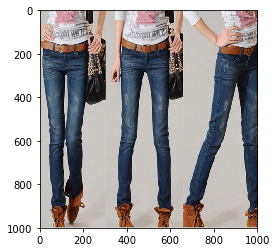

In [127]:
plotImage(train_images[num][1])

In [ ]:
X = np.array(list(map(float,x)))
Y = np.array(list(map(float,y)))

In [94]:
X = np.reshape(X,(14681,1))
Y = np.reshape(Y,(14681,1))

In [108]:
regr =  linear_model.LinearRegression(fit_intercept=True)

In [109]:
lin_model = regr.fit(X=X,y=Y)

In [111]:
regr.coef_

array([[ 0.70899058]])

In [110]:
regr.intercept_

array([ 110.38239567])

# Equation Governing Aspect Ratio

In [116]:
Y_ = lambda x: 0.7*x + 110

In [117]:
Y_(475)

442.5

In [121]:
def plotImageResized(image):
    plt.imshow(cv2.cvtColor(cv2.resize(image, (475,442)), cv2.COLOR_BGR2RGB))
    plt.show()

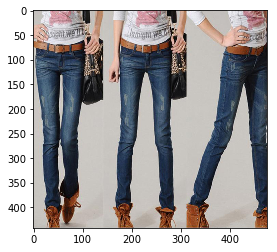

In [128]:
plotImageResized(train_images[num][1])

# 475, 442 looks like a good aspect ratio